<a href="https://colab.research.google.com/github/karT0IIIecHka/Task-from-the-kaggle/blob/main/%D0%AF%D0%BA%D0%BE%D0%B2%D0%BB%D0%B5%D0%B2_%D0%94_%D0%92_%D0%AD%D0%BA%D0%B7%D0%B0%D0%BC%D0%B5%D0%BD_%D0%92%D0%B0%D1%80%D0%B8%D0%B0%D0%BD%D1%82_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Демо-экзамен по курсу "Прикладной анализ данных". Вариант 1

## 1. Описание задачи и данные

В 4 километрах от тихоокеанского берега Камчатки в бухте Вестник лежит остров Уташуд — часть Южно-Камчатского федерального заказника. На нем живут каланы, антуры, тюлени ларги, около 50 тысяч птиц десяти разных видов, включая  колонию топорика численностью 10 тыс. пар. В данной задаче нас интересуют двое обитатаелей острова – ларга и техоокеанская чайка, за которыми осуществляется наблюдение через фотоловушки в летний сезон.

На Уташуде находится репродуктивное лежбище тюленей-ларга  и одно из крупнейших на Камчатке поселений тихоокеанской чайки (4 тыс. пар). За 1 сезон наблюдения за этими животными может накопится более 1800 фотографий различного качества. Через эти фотографии инспекторы оценивают благополучие и численность животных.

Разработайте алгоритм, который бы позволил производить учет чаек и выделять их по фотографии.

Ссылка на соревнование и на данные: https://www.kaggle.com/competitions/where-are-the-seagulls

In [ ]:
# Import libraries
# TODO

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Пропишите дополнительные библиотеки, которые потребуются для решения

import os
from sklearn.model_selection import train_test_split
import shutil
import yaml
from tqdm import tqdm
import os
import cv2
import random

In [ ]:
# установим библиотеку для работы с датасетами на kaggle
!pip install opendatasets --quiet

Небольшая инструкция как напрямую скачать данные с kaggle в Colab ноутбук: https://www.geeksforgeeks.org/python/how-to-import-kaggle-datasets-directly-into-google-colab/

In [ ]:
import opendatasets as od
import pandas as pd

url = 'https://www.kaggle.com/competitions/where-are-the-seagulls'
od.download(url)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dem0n1c
Your Kaggle Key: ··········


100%|██████████| 36.7M/36.7M [00:00<00:00, 1.35GB/s]


Extracting archive ./where-are-the-seagulls/where-are-the-seagulls.zip to ./where-are-the-seagulls


## 1. Провести предварительное исследование данных

- в каком формате вам предоставлены данные?
- какие есть особенности датасета?
- если необходимо произвести очистку и предварительную обработку данных.

# Формат данных:

- train/images/ - Папка содержит все тренировочные изображения
- train/labels/ - Папка содержит аннотации для каждого изображения в формате .txt

Формат .txt - YOLO format датасете:

class_id, x_center, y_center, width, height

Где:

- class_id: идентификатор класса (целое число)
- x_center, y_center: центр bbox по ширине и высоте
- width, height: размеры bbox

Особенности:

Один .txt может содержать несколько строк, если на изображении несколько объектов. Или не содержать строк совсем.

test/images/ - Папка содержит изображения для теста — без аннотаций. Участники должны предсказать bounding boxes для этих изображений.

Посмотрим на 4 случайные картинки и визуализируем их с разметкой:

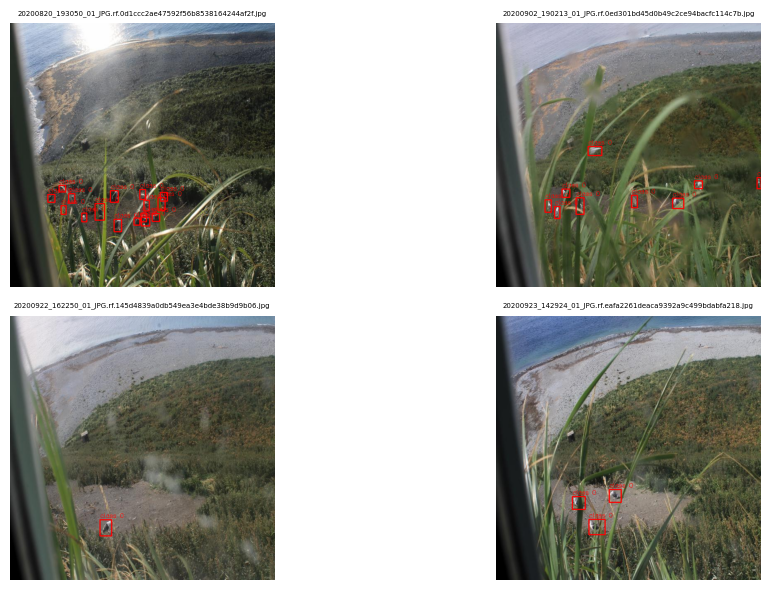

In [ ]:


# === Папки с изображениями и разметкой ===
img_dir = '/content/where-are-the-seagulls/data/train/images'
label_dir = '/content/where-are-the-seagulls/data/train/labels'

# === Берем 4 любых изображения ===
image_files = sorted([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
selected_images = random.sample(image_files, 4)

def draw_boxes(img_path, label_path):
    # Читаем изображение
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # из BGR в RGB для корректного отображения

    h, w, _ = img.shape  # размер изображения

    # Если аннотации нет — просто возвращаем изображение
    if not os.path.exists(label_path):
        return img

    # Читаем аннотацию в формате YOLO
    with open(label_path, 'r') as f:
        lines = f.read().strip().split('\n')

    for line in lines:
        if not line:
            continue
        class_id, x_center, y_center, bw, bh = map(float, line.strip().split())

        # Переводим координаты из нормированных в пиксели
        x_center *= w
        y_center *= h
        bw *= w
        bh *= h

        # Вычисляем координаты углов
        x1 = int(x_center - bw / 2)
        y1 = int(y_center - bh / 2)
        x2 = int(x_center + bw / 2)
        y2 = int(y_center + bh / 2)

        # Рисуем прямоугольник
        cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)
        cv2.putText(img, f'class {int(class_id)}', (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (255, 0, 0), 1)

    return img

# === Отображаем изображения с разметкой ===
plt.figure(figsize=(12, 6))

for i, img_file in enumerate(selected_images):
    img_path = os.path.join(img_dir, img_file)
    label_path = os.path.join(label_dir, os.path.splitext(img_file)[0] + '.txt')

    img_with_boxes = draw_boxes(img_path, label_path)

    plt.subplot(2, 2, i+1)
    plt.imshow(img_with_boxes)
    plt.title(img_file, fontsize=5)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Соберём общую статистику:

Всего изображений: 500
Пустых изображений: 32 (6.40%)
Изображений с 1 объектом: 26 (5.20%)
Изображений с несколькими объектами: 442 (88.40%)
Общее количество объектов: 5386
Среднее количество объектов на изображение: 10.77
Максимальное количество объектов на изображении: 39

Статистика по размерам объектов:
Средний размер объекта: 0.12% от площади изображения
Минимальный размер: 0.00%
Максимальный размер: 2.99%
Медианный размер: 0.10%


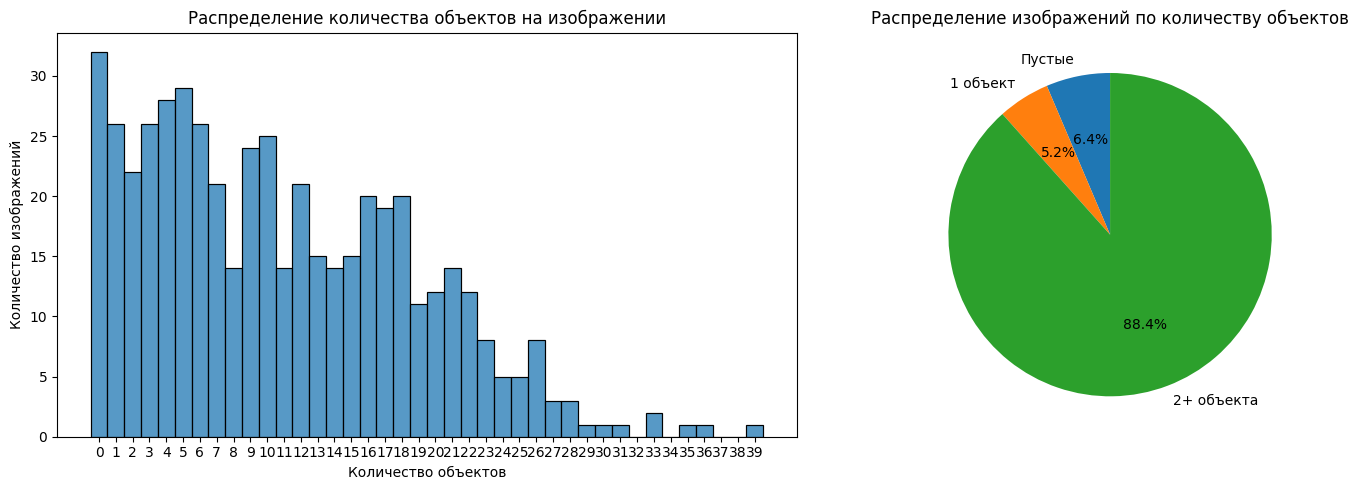

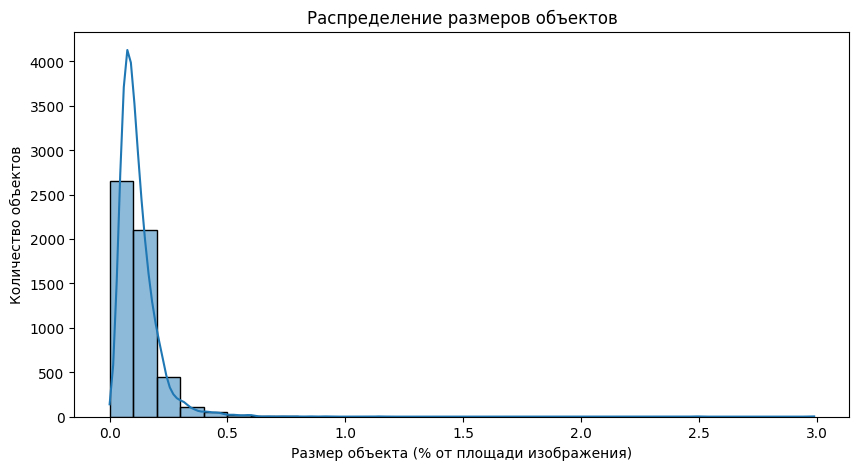

In [ ]:
# Собираем статистику
stats = {
    'total_images': 0,
    'empty_images': 0,
    'single_object': 0,
    'multiple_objects': 0,
    'objects_per_image': [],
    'total_objects': 0,
    'object_sizes': []  # будем хранить площади объектов (относительные)
}

# Анализ каждого файла разметки
for label_file in os.listdir(label_dir):
    if not label_file.endswith('.txt'):
        continue

    stats['total_images'] += 1
    file_path = os.path.join(label_dir, label_file)

    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines() if line.strip()]

    num_objects = len(lines)

    # Обновляем статистику по количеству объектов
    if num_objects == 0:
        stats['empty_images'] += 1
    elif num_objects == 1:
        stats['single_object'] += 1
    else:
        stats['multiple_objects'] += 1

    stats['objects_per_image'].append(num_objects)
    stats['total_objects'] += num_objects

    # Анализ размеров объектов (для YOLO формат: class x_center y_center width height)
    for line in lines:
        _, _, _, w, h = map(float, line.split())
        stats['object_sizes'].append(w * h)  # относительная площадь объекта

# Проверяем, есть ли объекты вообще
has_objects = stats['total_objects'] > 0

# Вывод статистики
print(f"Всего изображений: {stats['total_images']}")
print(f"Пустых изображений: {stats['empty_images']} ({stats['empty_images']/stats['total_images']*100:.2f}%)")
print(f"Изображений с 1 объектом: {stats['single_object']} ({stats['single_object']/stats['total_images']*100:.2f}%)")
print(f"Изображений с несколькими объектами: {stats['multiple_objects']} ({stats['multiple_objects']/stats['total_images']*100:.2f}%)")
print(f"Общее количество объектов: {stats['total_objects']}")
print(f"Среднее количество объектов на изображение: {np.mean(stats['objects_per_image']):.2f}")
print(f"Максимальное количество объектов на изображении: {max(stats['objects_per_image']) if stats['total_images'] > 0 else 0}")

if has_objects:
    print(f"\nСтатистика по размерам объектов:")
    print(f"Средний размер объекта: {np.mean(stats['object_sizes'])*100:.2f}% от площади изображения")
    print(f"Минимальный размер: {np.min(stats['object_sizes'])*100:.2f}%")
    print(f"Максимальный размер: {np.max(stats['object_sizes'])*100:.2f}%")
    print(f"Медианный размер: {np.median(stats['object_sizes'])*100:.2f}%")

# Визуализация
plt.figure(figsize=(15, 5))

# Гистограмма количества объектов на изображении
plt.subplot(1, 2, 1)
sns.histplot(stats['objects_per_image'], bins=30, kde=False, discrete=True)
plt.title('Распределение количества объектов на изображении')
plt.xlabel('Количество объектов')
plt.ylabel('Количество изображений')
plt.xticks(range(max(stats['objects_per_image']) + 1))

# Круговая диаграмма распределения изображений
plt.subplot(1, 2, 2)
categories = ['Пустые', '1 объект', '2+ объекта']
values = [stats['empty_images'], stats['single_object'], stats['multiple_objects']]
plt.pie(values, labels=categories, autopct='%1.1f%%', startangle=90)
plt.title('Распределение изображений по количеству объектов')

plt.tight_layout()
plt.show()

# Дополнительная визуализация размеров объектов
if has_objects:
    plt.figure(figsize=(10, 5))
    sns.histplot(np.array(stats['object_sizes'])*100, bins=30, kde=True)
    plt.title('Распределение размеров объектов')
    plt.xlabel('Размер объекта (% от площади изображения)')
    plt.ylabel('Количество объектов')
    plt.show()

# Что видно:

*   На большинстве изображений более одного объекта (всего 5% изображений
содержат 1 объект - таких 26 штук)
*   32 пустых изображения (без искомых объектов вообще)

Всего один класс искомых объектов - чаек

Таким образом, надо аккуратно распределить по подвыборкам (train и val):

- пустые изображения
- изображения, где искомые объекты мелкие
- изображения, где искомые объекты большие

## 2. Подготовить данные для обучения

- Создать тренировочную и тестовую подвыборки для обучения и тестирования работы моделей
- Создать класс на фреймворке `PyTorch` для создания датасета
- Создать `loader` для передачи данных в модель нейронной сети

*P.s.: если вам удобнее использовать Keras или другой формат обработки данных и построения моделей, вы можете их использовать, не обязательно идти по пути `PyTorch` и `loader`.

Возможно вам это поможет: https://docs.ultralytics.com/datasets/detect/#ultralytics-yolo-format

# Разделяем датасет

In [ ]:


def create_dataset_split(images_dir, labels_dir, output_dir, val_ratio=0.15, seed=42):
    """
    Создает стратифицированное разделение датасета на train/val
    с сохранением распределения по количеству объектов и их размерам

    Параметры:
        images_dir: путь к папке с изображениями
        labels_dir: путь к папке с аннотациями YOLO
        output_dir: папка для сохранения результатов
        val_ratio: доля val выборки (по умолчанию 15%)
        seed: random seed для воспроизводимости
    """
    # Создаем выходные директории
    os.makedirs(output_dir, exist_ok=True)
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    os.makedirs(os.path.join(train_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(train_dir, 'labels'), exist_ok=True)
    os.makedirs(os.path.join(val_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(val_dir, 'labels'), exist_ok=True)

    # Собираем метаданные
    meta = []
    for label_file in tqdm(os.listdir(labels_dir), desc='Анализ данных'):
        if not label_file.endswith('.txt'):
            continue

        image_file = label_file.replace('.txt', '.jpg')
        if not os.path.exists(os.path.join(images_dir, image_file)):
            continue

        label_path = os.path.join(labels_dir, label_file)
        with open(label_path, 'r') as f:
            lines = [line.strip() for line in f.readlines() if line.strip()]

        num_objects = len(lines)
        object_sizes = []

        for line in lines:
            _, _, _, w, h = map(float, line.split())
            object_sizes.append(w * h)

        avg_size = np.mean(object_sizes) if object_sizes else 0
        meta.append({
            'image': image_file,
            'label': label_file,
            'num_objects': num_objects,
            'avg_object_size': avg_size
        })

    df = pd.DataFrame(meta)

    # Создаем страты для стратификации
    df['strata'] = pd.cut(df['num_objects'],
                          bins=[-1, 0, 1, 5, 10, 20, 100],
                          labels=['empty', '1', '2-5', '6-10', '11-20', '20+'])

    # Стратифицированное разделение
    train_df, val_df = train_test_split(
        df,
        test_size=val_ratio,
        random_state=seed,
        stratify=df['strata']
    )

    # Копируем файлы в соответствующие директории
    for _, row in tqdm(train_df.iterrows(), desc='Создание train set'):
        shutil.copy(
            os.path.join(images_dir, row['image']),
            os.path.join(train_dir, 'images', row['image']))
        shutil.copy(
            os.path.join(labels_dir, row['label']),
            os.path.join(train_dir, 'labels', row['label']))

    for _, row in tqdm(val_df.iterrows(), desc='Создание val set'):
        shutil.copy(
            os.path.join(images_dir, row['image']),
            os.path.join(val_dir, 'images', row['image']))
        shutil.copy(
            os.path.join(labels_dir, row['label']),
            os.path.join(val_dir, 'labels', row['label']))

    # Создаем dataset.yaml файл для YOLO
    data_yaml = {
        'train': os.path.abspath(os.path.join(train_dir, 'images')),
        'val': os.path.abspath(os.path.join(val_dir, 'images')),
        'nc': 1,
        'names': ['object']
    }

    with open(os.path.join(output_dir, 'dataset.yaml'), 'w') as f:
        yaml.dump(data_yaml, f)

    # Генерируем отчет о разделении
    generate_report(train_df, val_df, output_dir)

    print(f"\nРазделение завершено. Train: {len(train_df)} изображений, Val: {len(val_df)} изображений")
    print(f"Файл конфигурации сохранен в {os.path.join(output_dir, 'dataset.yaml')}")

def generate_report(train_df, val_df, output_dir):
    """Генерирует отчет о разделении датасета"""
    # Создаем словарь с данными для отчета
    report_data = {
        'Общая статистика': pd.DataFrame({
            'Метрика': ['Всего изображений', 'Train изображений', 'Val изображений', 'Соотношение train/val'],
            'Значение': [
                len(train_df) + len(val_df),
                len(train_df),
                len(val_df),
                f"{len(train_df)/len(val_df):.2f}:1"
            ]
        }),

        'Распределение по количеству объектов': pd.DataFrame({
            'Тип': ['Пустые', '1 объект', '2-5 объектов', '6-10 объектов', '11-20 объектов', '20+ объектов'],
            'Train': [
                len(train_df[train_df['num_objects'] == 0]),
                len(train_df[train_df['num_objects'] == 1]),
                len(train_df[(train_df['num_objects'] >= 2) & (train_df['num_objects'] <= 5)]),
                len(train_df[(train_df['num_objects'] >= 6) & (train_df['num_objects'] <= 10)]),
                len(train_df[(train_df['num_objects'] >= 11) & (train_df['num_objects'] <= 20)]),
                len(train_df[train_df['num_objects'] > 20])
            ],
            'Val': [
                len(val_df[val_df['num_objects'] == 0]),
                len(val_df[val_df['num_objects'] == 1]),
                len(val_df[(val_df['num_objects'] >= 2) & (val_df['num_objects'] <= 5)]),
                len(val_df[(val_df['num_objects'] >= 6) & (val_df['num_objects'] <= 10)]),
                len(val_df[(val_df['num_objects'] >= 11) & (val_df['num_objects'] <= 20)]),
                len(val_df[val_df['num_objects'] > 20])
            ]
        }),

        'Статистика по размерам объектов': pd.DataFrame({
            'Метрика': ['Средний размер', 'Медианный размер', 'Минимальный', 'Максимальный'],
            'Train': [
                f"{train_df['avg_object_size'].mean()*100:.4f}%",
                f"{train_df['avg_object_size'].median()*100:.4f}%",
                f"{train_df['avg_object_size'].min()*100:.4f}%",
                f"{train_df['avg_object_size'].max()*100:.4f}%"
            ],
            'Val': [
                f"{val_df['avg_object_size'].mean()*100:.4f}%",
                f"{val_df['avg_object_size'].median()*100:.4f}%",
                f"{val_df['avg_object_size'].min()*100:.4f}%",
                f"{val_df['avg_object_size'].max()*100:.4f}%"
            ]
        })
    }

    # Сохраняем отчет в файл
    report_path = os.path.join(output_dir, 'split_report.txt')
    with open(report_path, 'w') as f:
        f.write("ОТЧЕТ О РАЗДЕЛЕНИИ ДАТАСЕТА\n")
        f.write("="*50 + "\n\n")

        for section, df in report_data.items():
            f.write(f"{section}:\n")
            f.write(df.to_string(index=False))  # Убираем индексы для красоты
            f.write("\n\n")

    print(f"\nОтчет сохранен в {report_path}")

# Пример использования
if __name__ == "__main__":
    images_dir = "/content/where-are-the-seagulls/data/train/images"
    labels_dir = "/content/where-are-the-seagulls/data/train/labels"
    output_dir = "/content/where-are-the-seagulls/dataset"

    create_dataset_split(images_dir, labels_dir, output_dir, val_ratio=0.15)

Анализ данных: 100%|██████████| 500/500 [00:00<00:00, 15762.02it/s]
Создание train set: 425it [00:00, 1696.79it/s]
Создание val set: 75it [00:00, 1750.81it/s]



Отчет сохранен в /content/where-are-the-seagulls/dataset/split_report.txt

Разделение завершено. Train: 425 изображений, Val: 75 изображений
Файл конфигурации сохранен в /content/where-are-the-seagulls/dataset/dataset.yaml


**ОТЧЕТ О РАЗДЕЛЕНИИ ДАТАСЕТА**

Общая статистика:

    Всего изображений       500
    Train изображений       425
    Val изображений         75
    Соотношение train/val   5.67:1

Распределение по количеству объектов:

                    Train  Val
    Пустые          27    5
    1 объект        22    4
    2-5 объектов    89    16
    6-10 объектов   94    16
    11-20 объектов  137   24
    20+ объектов    56    10

Статистика по размерам объектов:

                      Train     Val
    Средний размер    0.1168%   0.1125%
    Медианный размер  0.1149%   0.1134%
    Минимальный       0.0000%   0.0000%
    Максимальный      0.3866%   0.2344%

## 3. Реализация модели

- создать класс для модели
- создать функцию для обучения модели
- создать функцию для валидации модели

Этот шаг проигнорирован, так как я использовал библиотеку `ultralytics`, содержащую предобученные модели YOLO

## 4. Обучение модели
*   Определить необходимые параметры для обучения модели (learning rate, optimizer, loss function, etc)
*   Реализовать процесс обучения модели
*   Оценить эффективность работы модели



In [ ]:
!pip install ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.2 MB/s eta 0:00:00


In [ ]:
# === 2. Обучение YOLO ===

from ultralytics import YOLO

# Загружаем легкую модель YOLO (можно взять yolov8n.pt, yolov8s.pt и т.д.)
model = YOLO('yolov8n.pt')

# Обучение
model.train(
    data='/content/where-are-the-seagulls/dataset/dataset.yaml',  # путь к конфигу данных
    epochs=10,
    imgsz=640
)

Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/where-are-the-seagulls/dataset/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train6, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=Tr

train: Scanning /content/where-are-the-seagulls/dataset/train/labels.cache... 425 images, 27 backgrounds, 0 corrupt: 100%|██████████| 425/425 [00:00<?, ?it/s]

train: /content/where-are-the-seagulls/dataset/train/images/20200816_180222_01_JPG.rf.5f3bc87ff01f17b2a00c3ecf18d14ac5.jpg: 2 duplicate labels removed
train: /content/where-are-the-seagulls/dataset/train/images/20200819_182328_01_JPG.rf.cca24be539aa73a24a2bf112ab67fe68.jpg: 3 duplicate labels removed
train: /content/where-are-the-seagulls/dataset/train/images/20200910_185837_01_JPG.rf.cdf85cd8e98797d94fb93d972d58fc5f.jpg: 1 duplicate labels removed
train: /content/where-are-the-seagulls/dataset/train/images/20200913_121758_01_JPG.rf.126b4bd798cd834f2c08f1c85a6fee70.jpg: 1 duplicate labels removed
train: /content/where-are-the-seagulls/dataset/train/images/20200913_171925_01_JPG.rf.de1d151832416a3f2df30dcdbf84bf8a.jpg: 3 duplicate labels removed
train: /content/where-are-the-seagulls/dataset/train/images/20200924_183741_01_JPG.rf.cbc768e717616cc48643dba4f3a76bbd.jpg: 3 duplicate labels removed


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 13.6±6.3 MB/s, size: 47.3 KB)


val: Scanning /content/where-are-the-seagulls/dataset/val/labels.cache... 75 images, 5 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]


Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train6
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.12G      2.333      2.634      1.243         85        640: 100%|██████████| 27/27 [00:10<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


                   all         75        828     0.0154      0.418     0.0161    0.00565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10       2.6G       2.12      1.573      1.137        117        640: 100%|██████████| 27/27 [00:07<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.51it/s]

                   all         75        828     0.0286      0.777      0.229     0.0609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.61G      2.064      1.419      1.141         86        640: 100%|██████████| 27/27 [00:06<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all         75        828      0.715      0.322      0.484      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.61G      2.024      1.407      1.116         50        640: 100%|██████████| 27/27 [00:06<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]

                   all         75        828      0.705       0.62      0.678      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.62G      2.028      1.299      1.132         80        640: 100%|██████████| 27/27 [00:07<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.73it/s]

                   all         75        828      0.657      0.623      0.647      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.62G      2.009      1.253      1.118         61        640: 100%|██████████| 27/27 [00:06<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.03it/s]

                   all         75        828      0.776      0.669      0.736      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.62G      1.964      1.221      1.093         89        640: 100%|██████████| 27/27 [00:07<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.26it/s]

                   all         75        828      0.797      0.703      0.778      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.62G      1.917      1.178      1.091        112        640: 100%|██████████| 27/27 [00:06<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         75        828      0.786      0.715      0.777      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.63G      1.896      1.112      1.089         96        640: 100%|██████████| 27/27 [00:06<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.07it/s]

                   all         75        828      0.843      0.702      0.796      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.63G      1.858      1.094      1.066        126        640: 100%|██████████| 27/27 [00:07<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]

                   all         75        828      0.806       0.73      0.799      0.357



10 epochs completed in 0.024 hours.
Optimizer stripped from runs/detect/train6/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train6/weights/best.pt, 6.2MB

Validating runs/detect/train6/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


                   all         75        828      0.805      0.729        0.8      0.357
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/detect/train6


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c6f3ec8c350>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

**Как видим на GPU 10 эпох обучились за 0.025 hours**

In [ ]:


test_dir = '/content/where-are-the-seagulls/data/test/images'

# === Получаем список изображений из test ===
image_files = sorted([f for f in os.listdir(test_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])

# === Предсказания и формирование строк submission.csv ===
submission = []

for idx, image_name in enumerate(image_files):
    image_path = os.path.join(test_dir, image_name)
    results = model(image_path, verbose=False)[0]

    # Достаем боксы (xywhn = нормализованные координаты центра + ширина/высота)
    boxes = results.boxes
    if boxes is None or boxes.xywhn.shape[0] == 0:
        submission.append([idx, image_name, "-1"])
    else:
        yolo_str = ""
        for box in boxes.xywhn:
            x_center, y_center, w, h = box.tolist()
            yolo_str += f"0 {x_center:.4f} {y_center:.4f} {w:.4f} {h:.4f} "
        yolo_str = yolo_str.strip()
        submission.append([idx, image_name, yolo_str])

# === Сохраняем в CSV ===

df = pd.DataFrame(submission, columns=["index", "filename", "bbox"])

df.to_csv('my_submit.csv', index=False)

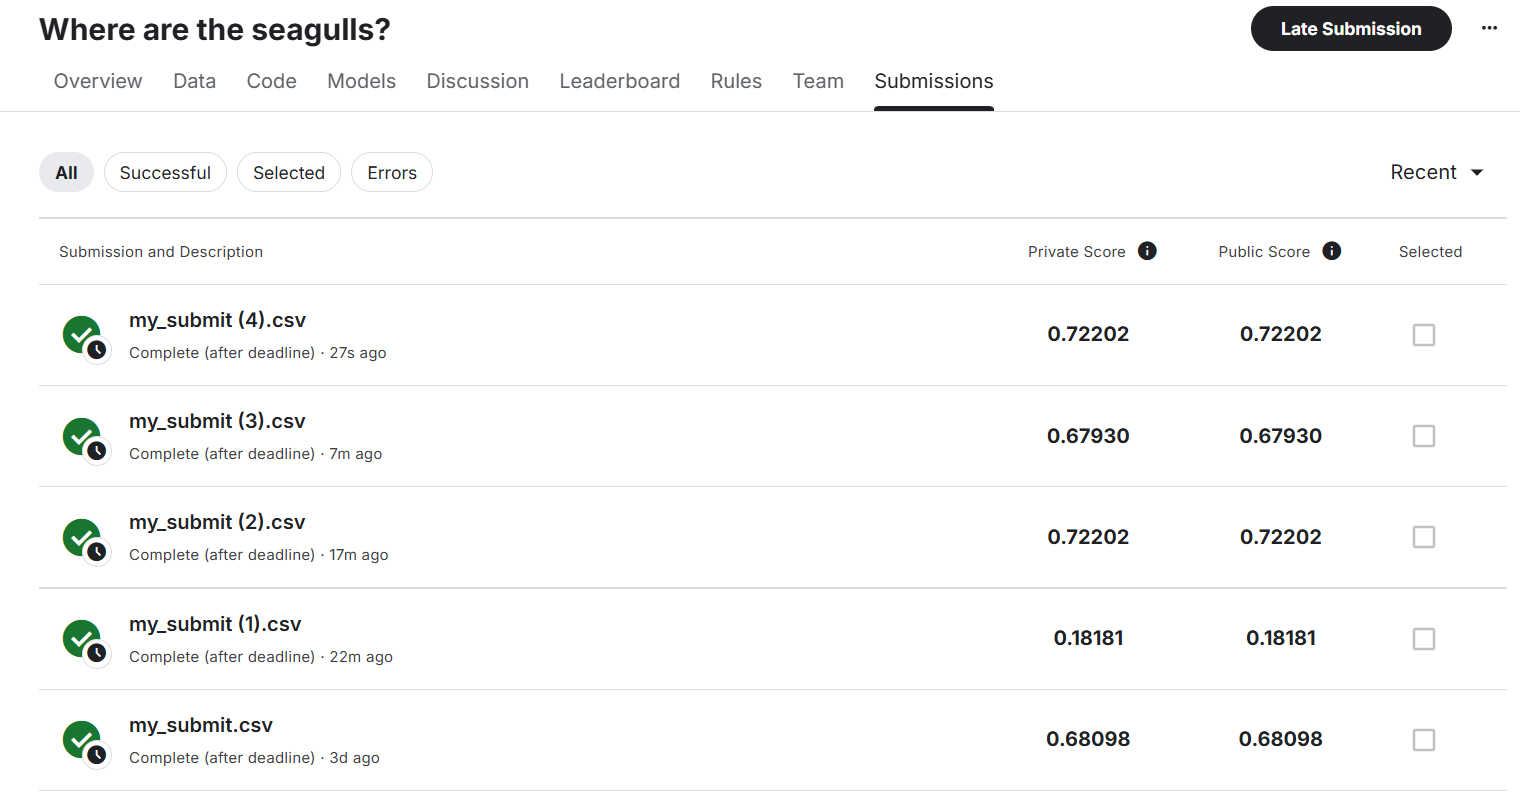

Самое нижнее решение - предсказание нейросети, у которой выборка НЕ была разделена на train и val, т.е. она проверяла себя на данных, на которых училась

Забавно, что когда я разделил датасет train на train и val точность упала до 0.18181)

Далее я экспериментировал с количеством эпох обучения, остановился на 10.

## 5. Экспериментальная часть

- протестировать не менее 3х разных моделей для решения задачи
- сравнить их эффективность (по метрикам и потерям)
- сделать выводы

In [ ]:
# Создадим функцию, которая делает предсказание

def create_csv(model, file_name):
  """
    Создает csv файл с предсказанием
    Параметры:
        model: обученная модель
        file_name: имя файла, который необхожимо создать
    """
  test_dir = '/content/where-are-the-seagulls/data/test/images'

  # === Получаем список изображений из test ===
  image_files = sorted([f for f in os.listdir(test_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])

  # === Предсказания и формирование строк submission.csv ===
  submission = []

  for idx, image_name in enumerate(image_files):
      image_path = os.path.join(test_dir, image_name)
      results = model(image_path, verbose=False)[0]

      # Достаем боксы (xywhn = нормализованные координаты центра + ширина/высота)
      boxes = results.boxes
      if boxes is None or boxes.xywhn.shape[0] == 0:
          submission.append([idx, image_name, "-1"])
      else:
          yolo_str = ""
          for box in boxes.xywhn:
              x_center, y_center, w, h = box.tolist()
              yolo_str += f"0 {x_center:.4f} {y_center:.4f} {w:.4f} {h:.4f} "
          yolo_str = yolo_str.strip()
          submission.append([idx, image_name, yolo_str])

  # === Сохраняем в CSV ===

  df = pd.DataFrame(submission, columns=["index", "filename", "bbox"])

  df.to_csv(file_name, index=False)

Для начала, посмотрим как справится yolov5s

In [ ]:
model_yolov5s = YOLO('yolov5s.pt')

# Обучение
model_yolov5s.train(
    data='/content/where-are-the-seagulls/dataset/dataset.yaml',  # путь к конфигу данных
    epochs=10,
    imgsz=640
)

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/where-are-the-seagulls/dataset/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lr

train: Scanning /content/where-are-the-seagulls/dataset/train/labels.cache... 425 images, 27 backgrounds, 0 corrupt: 100%|██████████| 425/425 [00:00<?, ?it/s]

train: /content/where-are-the-seagulls/dataset/train/images/20200816_180222_01_JPG.rf.5f3bc87ff01f17b2a00c3ecf18d14ac5.jpg: 2 duplicate labels removed
train: /content/where-are-the-seagulls/dataset/train/images/20200819_182328_01_JPG.rf.cca24be539aa73a24a2bf112ab67fe68.jpg: 3 duplicate labels removed
train: /content/where-are-the-seagulls/dataset/train/images/20200910_185837_01_JPG.rf.cdf85cd8e98797d94fb93d972d58fc5f.jpg: 1 duplicate labels removed
train: /content/where-are-the-seagulls/dataset/train/images/20200913_121758_01_JPG.rf.126b4bd798cd834f2c08f1c85a6fee70.jpg: 1 duplicate labels removed
train: /content/where-are-the-seagulls/dataset/train/images/20200913_171925_01_JPG.rf.de1d151832416a3f2df30dcdbf84bf8a.jpg: 3 duplicate labels removed
train: /content/where-are-the-seagulls/dataset/train/images/20200924_183741_01_JPG.rf.cbc768e717616cc48643dba4f3a76bbd.jpg: 3 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 392.6±85.6 MB/s, size: 47.3 KB)


val: Scanning /content/where-are-the-seagulls/dataset/val/labels.cache... 75 images, 5 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.19G      2.299      2.144       1.28         85        640: 100%|██████████| 27/27 [00:10<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]

                   all         75        828      0.408      0.546      0.346      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      4.97G      2.063       1.28      1.145        117        640: 100%|██████████| 27/27 [00:07<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]

                   all         75        828      0.532      0.483      0.461      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.97G      2.021      1.244      1.147         86        640: 100%|██████████| 27/27 [00:07<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.23it/s]

                   all         75        828      0.707      0.591      0.629      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         5G      2.052      1.187      1.149         50        640: 100%|██████████| 27/27 [00:08<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.34it/s]

                   all         75        828      0.701      0.599      0.658      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         5G      2.001      1.114      1.149         80        640: 100%|██████████| 27/27 [00:08<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]

                   all         75        828       0.71      0.644      0.681      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         5G      1.948      1.063      1.124         61        640: 100%|██████████| 27/27 [00:07<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.24it/s]

                   all         75        828      0.823      0.717      0.788       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         5G       1.95      1.045       1.11         89        640: 100%|██████████| 27/27 [00:08<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.30it/s]

                   all         75        828      0.752      0.702      0.769      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      5.03G      1.868      1.006      1.097        112        640: 100%|██████████| 27/27 [00:08<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]

                   all         75        828      0.833      0.733      0.816       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      5.03G      1.853     0.9756      1.089         96        640: 100%|██████████| 27/27 [00:07<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.55it/s]

                   all         75        828      0.792       0.73      0.817      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      5.03G      1.824     0.9429      1.072        126        640: 100%|██████████| 27/27 [00:08<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]

                   all         75        828       0.87      0.744      0.844      0.384



10 epochs completed in 0.027 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 18.5MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 18.5MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv5s summary (fused): 84 layers, 9,111,923 parameters, 0 gradients, 23.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


                   all         75        828      0.875      0.741      0.843      0.383
Speed: 0.3ms preprocess, 4.1ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f7e7eb81d50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
create_csv(model_yolov5s, 'my_submit_yolov5s.csv')

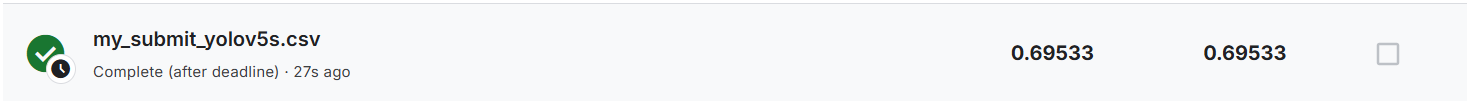

Эта модель обучилась за 0.027 hours

Точность *yolov5s* на тестовых данных **меньше** точности *yolov8n* на **0.02669**, однако в процессе обучения на тренировочных данных, метрики говорили о лучшей эффективности *yolov5s*

Box *yolov8n*:

    P        R        mAP50     mAP50-95
    0.805    0.729    0.8       0.357

 Box *yolov5s*:

    P        R        mAP50     mAP50-95
    0.875    0.741    0.843     0.383

In [ ]:
model_yolov9c = YOLO('yolov9c.pt')

# Обучение
model_yolov9c.train(
    data='/content/where-are-the-seagulls/dataset/dataset.yaml',  # путь к конфигу данных
    epochs=10,
    imgsz=640
)

100%|██████████| 49.4M/49.4M [00:00<00:00, 83.1MB/s]


Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/where-are-the-seagulls/dataset/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov9c.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=Tr

train: Scanning /content/where-are-the-seagulls/dataset/train/labels.cache... 425 images, 27 backgrounds, 0 corrupt: 100%|██████████| 425/425 [00:00<?, ?it/s]

train: /content/where-are-the-seagulls/dataset/train/images/20200816_180222_01_JPG.rf.5f3bc87ff01f17b2a00c3ecf18d14ac5.jpg: 2 duplicate labels removed
train: /content/where-are-the-seagulls/dataset/train/images/20200819_182328_01_JPG.rf.cca24be539aa73a24a2bf112ab67fe68.jpg: 3 duplicate labels removed
train: /content/where-are-the-seagulls/dataset/train/images/20200910_185837_01_JPG.rf.cdf85cd8e98797d94fb93d972d58fc5f.jpg: 1 duplicate labels removed
train: /content/where-are-the-seagulls/dataset/train/images/20200913_121758_01_JPG.rf.126b4bd798cd834f2c08f1c85a6fee70.jpg: 1 duplicate labels removed
train: /content/where-are-the-seagulls/dataset/train/images/20200913_171925_01_JPG.rf.de1d151832416a3f2df30dcdbf84bf8a.jpg: 3 duplicate labels removed
train: /content/where-are-the-seagulls/dataset/train/images/20200924_183741_01_JPG.rf.cbc768e717616cc48643dba4f3a76bbd.jpg: 3 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 358.9±113.7 MB/s, size: 47.3 KB)


val: Scanning /content/where-are-the-seagulls/dataset/val/labels.cache... 75 images, 5 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      10.6G      2.284      3.667      1.285         85        640: 100%|██████████| 27/27 [00:24<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]

                   all         75        828      0.136       0.58      0.105     0.0369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      10.9G      2.159      1.367      1.208        117        640: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all         75        828   0.000133    0.00362   6.77e-05   1.35e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      10.9G      2.082      1.257       1.19         86        640: 100%|██████████| 27/27 [00:20<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]

                   all         75        828          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10        11G      2.123      1.209      1.188         50        640: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]

                   all         75        828    0.00406      0.107    0.00223   0.000876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10        11G      2.054      1.135      1.177         80        640: 100%|██████████| 27/27 [00:22<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]

                   all         75        828      0.172      0.126     0.0456     0.0154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10        11G      1.938      1.062       1.13         61        640: 100%|██████████| 27/27 [00:21<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all         75        828      0.712      0.586      0.617      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      10.9G       1.96      1.039      1.117         89        640: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]

                   all         75        828      0.825       0.74      0.801      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      11.1G      1.898      1.011      1.123        112        640: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]

                   all         75        828      0.848      0.727      0.822      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10        11G      1.848     0.9447      1.101         96        640: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all         75        828      0.884      0.746      0.833      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10        11G      1.811     0.9231      1.078        126        640: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]

                   all         75        828      0.876      0.746      0.834      0.377



10 epochs completed in 0.080 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 51.6MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 51.6MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv9c summary (fused): 156 layers, 25,320,019 parameters, 0 gradients, 102.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


                   all         75        828      0.875      0.745      0.833      0.376
Speed: 0.2ms preprocess, 16.7ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/train4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f7e7fcd3950>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
create_csv(model_yolov9c, 'my_submit_yolov9c.csv')

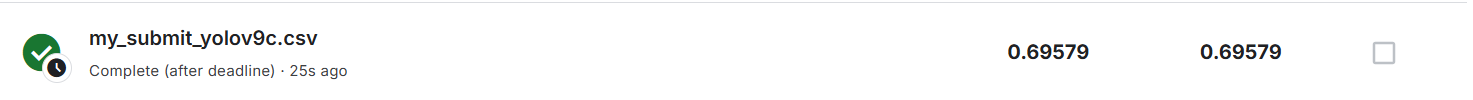

Модель обучилась за 0.080 hours (те же 10 эпох) и показала разницу в точности -0.02623 относительно *yolov8n*


Box *yolov8n* :

    P        R        mAP50     mAP50-95
    0.805    0.729    0.8       0.357

Box *yolov9c* :

    P        R        mAP50     mAP50-95
    0.875    0.745    0.833     0.376

In [ ]:
model_yolov8m = YOLO('yolov8m.pt')

# Обучение
model_yolov8m.train(
    data='/content/where-are-the-seagulls/dataset/dataset.yaml',  # путь к конфигу данных
    epochs=8,
    imgsz=640
)

Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/where-are-the-seagulls/dataset/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=8, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train7, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=Tru

train: Scanning /content/where-are-the-seagulls/dataset/train/labels.cache... 425 images, 27 backgrounds, 0 corrupt: 100%|██████████| 425/425 [00:00<?, ?it/s]

train: /content/where-are-the-seagulls/dataset/train/images/20200816_180222_01_JPG.rf.5f3bc87ff01f17b2a00c3ecf18d14ac5.jpg: 2 duplicate labels removed
train: /content/where-are-the-seagulls/dataset/train/images/20200819_182328_01_JPG.rf.cca24be539aa73a24a2bf112ab67fe68.jpg: 3 duplicate labels removed
train: /content/where-are-the-seagulls/dataset/train/images/20200910_185837_01_JPG.rf.cdf85cd8e98797d94fb93d972d58fc5f.jpg: 1 duplicate labels removed
train: /content/where-are-the-seagulls/dataset/train/images/20200913_121758_01_JPG.rf.126b4bd798cd834f2c08f1c85a6fee70.jpg: 1 duplicate labels removed
train: /content/where-are-the-seagulls/dataset/train/images/20200913_171925_01_JPG.rf.de1d151832416a3f2df30dcdbf84bf8a.jpg: 3 duplicate labels removed
train: /content/where-are-the-seagulls/dataset/train/images/20200924_183741_01_JPG.rf.cbc768e717616cc48643dba4f3a76bbd.jpg: 3 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 364.9±77.6 MB/s, size: 47.3 KB)


val: Scanning /content/where-are-the-seagulls/dataset/val/labels.cache... 75 images, 5 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]


Plotting labels to runs/detect/train7/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train7
Starting training for 8 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/8      6.29G      2.352      2.267      1.202        172        640: 100%|██████████| 27/27 [00:14<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]


                   all         75        828      0.307      0.504       0.23      0.091

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/8      6.49G      2.109       1.21       1.13        119        640: 100%|██████████| 27/27 [00:13<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all         75        828    0.00852      0.217    0.00513    0.00224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/8      6.36G      2.047      1.183      1.104        122        640: 100%|██████████| 27/27 [00:13<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]

                   all         75        828      0.752      0.647      0.711      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/8      6.39G      1.998      1.085      1.077        177        640: 100%|██████████| 27/27 [00:13<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all         75        828      0.653      0.582       0.59      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/8       6.2G          2      1.131      1.075        128        640: 100%|██████████| 27/27 [00:13<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]


                   all         75        828      0.528      0.554      0.467      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        6/8       7.4G      1.978      1.076      1.074        118        640: 100%|██████████| 27/27 [00:13<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all         75        828      0.728      0.659      0.717      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        7/8      6.35G      1.924     0.9927      1.051        162        640: 100%|██████████| 27/27 [00:13<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]

                   all         75        828      0.808      0.695      0.782      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        8/8      6.42G      1.843     0.9459      1.039         91        640: 100%|██████████| 27/27 [00:13<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all         75        828      0.783      0.774      0.827      0.372



8 epochs completed in 0.047 hours.
Optimizer stripped from runs/detect/train7/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train7/weights/best.pt, 52.0MB

Validating runs/detect/train7/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]


                   all         75        828      0.785      0.774      0.828      0.372
Speed: 0.3ms preprocess, 11.1ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detect/train7


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c6f3e982310>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
create_csv(model_yolov8m, 'my_submit_yolov8m.csv')

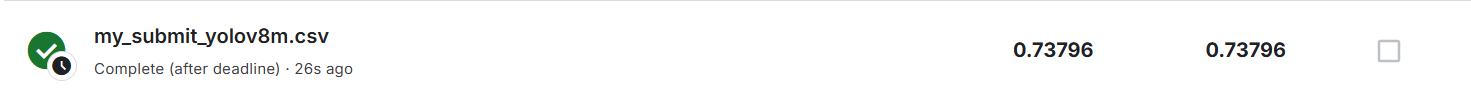

Модель обучилась за 0.080 hours (те же 10 эпох) и показала разницу в точности +0.01594 относительно *yolov8n*


Box *yolov8n* :

    P        R        mAP50     mAP50-95
    0.805    0.729    0.8       0.357

Box *yolov8m* :

    P        R        mAP50     mAP50-95
    0.785    0.774    0.828     0.372

# Подведение итогов эксперимента

Будем сравнивать модели по следующим параметрам:
- Precision (P) – точность: доля верно обнаруженных объектов среди всех предсказанных.

- Recall (R) – полнота: доль верно обнаруженных объектов среди всех истинных.

- mAP50 – средняя точность при IoU=0.5.

- mAP50-95 – средняя точность при IoU от 0.5 до 0.95 (более строгая метрика)
- Точность предсказания

1. **Precision (P)**

- YOLOv5s и YOLOv9c лидируют (0.875).

- YOLOv8n – 0.805.

- YOLOv8m – самый низкий (0.785).

  **Вывод:** YOLOv5s и YOLOv9c лучше фильтруют ложные обнаружения.

2. **Recall (R)**

- YOLOv8m лидирует (0.774).

- YOLOv9c – 0.745.

- YOLOv5s – 0.741.

- YOLOv8n – 0.729.

  **Вывод:** YOLOv8m лучше находит объекты, но у него ниже Precision.

3. **mAP50**
- YOLOv5s лидирует (0.843).

- YOLOv9c – 0.833.

- YOLOv8m – 0.828.

- YOLOv8n – 0.8.

  **Вывод:** YOLOv5s лучше всего сбалансирован по детекции при IoU=0.5.

4. **mAP50-95**
Чем выше, тем лучше модель работает при разных порогах IoU.

- YOLOv5s лидирует (0.383).

- YOLOv9c – 0.376.

- YOLOv8m – 0.372.

- YOLOv8n – 0.357.

  **Вывод:** YOLOv5s лучше обобщает на разных уровнях IoU.

5. **Точность предсказания**

- YOLOv8m лидирует (0.73796).

- YOLOv8n – 0.72202.

- YOLOv9c – 0.69579.

- YOLOv5s – 0.69533.

  **Вывод:** YOLOv8m показывает лучшую общую точность, несмотря на более низкие Precision и mAP.

# Итого:
1. Лучший баланс Precision/Recall/mAP: YOLOv5s – лидер по mAP и Precision, но немного уступает в Recall.

2. Лучшая точность: YOLOv8m – лучшая в Recall и общей точности, но хуже в Precision.

3. YOLOv9c – близок к YOLOv5s, но немного хуже по mAP.

4. YOLOv8n – самая легкая (nano-версия), но проигрывает по всем метрикам.